# `010-nonlinearity-sequential`

Task: Use `nn.Sequential` and a nonlinearity to increase the representation power of a NN.

## Setup

In [1]:
from fastai.vision.all import *

This function will make a `DataLoaders` object out of an arary dataset.

In [2]:
def make_dataloaders(x, y_true, splitter, batch_size):
    data = L(zip(x, y_true))
    train_indices, valid_indices = splitter(data)
    return DataLoaders(
        DataLoader(data[train_indices], batch_size=batch_size, shuffle=True),
        DataLoader(data[valid_indices], batch_size=batch_size)
    )   

Here are utility functions to plot the first axis of a dataset and a model's predictions.

In [3]:
def plot_data(x, y): plt.scatter(x[:, 0], y[:, 0], s=1, color='#888888')
def plot_model(x, model):
    x = x.sort(dim=0).values
    y_pred = model(x).detach()
    plt.plot(x[:, 0], y_pred[:, 0], 'r')

The following `Callback` can be added to your `Learner` to plot the data and model after each epoch:

```
learner = Learner(
    ...
    cbs=[ShowPredictions(), ShowGraphCallback()],
    ...
```

In [4]:
# Inspired by https://gist.github.com/oguiza/c7559da6de0e036f01d7dee15e2f15e4
class ShowPredictions(Callback):
    def __init__(self): self.graph_fig = None # keep a reference to a figure object to update
    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, 'gather_preds')
    def after_fit(self): plt.close(self.graph_fig)
    def after_epoch(self):
        if self.graph_fig is None:
            self.graph_fig, self.graph_ax = plt.subplots(1)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        plt.sca(self.graph_ax)
        self.graph_ax.clear()
        # Plot code. Replace this if needed:
        plot_data(x, y_true)
        plot_model(x, model)
        # Update the graph.
        self.graph_out.update(self.graph_ax.figure)


## Task

Like in `006` and `009`, let's suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`. But this time the data isn't just a straight line.

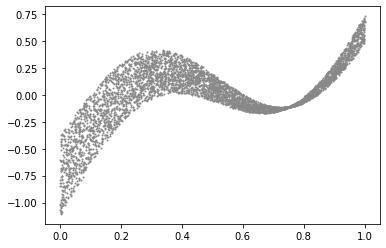

In [5]:
num_points = 5000

set_seed(40)
x = torch.rand(num_points, 1)
noise = torch.rand_like(x) * 1.
y_true = .5 * (x*6).sin() + x + (x - .75) * noise
y_true -= y_true.mean()

plot_data(x, y_true)

Let's try to learn this function! We'll first do a linear regression, then extend it to a simple neural network.

We increased the dataset size and the batch size to make the learning better-behaved. Once you get this to work, see if you can deal with a smaller batch size or less data overall.

In [6]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
batch_size = 100
dataloaders = make_dataloaders(x, y_true, splitter, batch_size=batch_size)

1. Fit a line to this data (minimizing the MSE). Evaluate the MSE. By eye, how well does it fit?
2. Use `nn.Sequential` to put two `nn.Linear` layers back to back. Use 200 dimensions as the hidden dimension (the `out_features` of the first and the `in_features` of the second). Evaluate the MSE. How well does it fit?
3. Now, add a `nn.ReLU` between the two linear layers. Evaluate the MSE. How well does it fit?

## Solution

**Fit a line to this data (minimizing the MSE).**

epoch,train_loss,valid_loss,mae,time
0,0.582536,0.571061,0.708069,00:00
1,0.573576,0.551953,0.693967,00:00
2,0.551922,0.512313,0.663724,00:00
3,0.515790,0.456882,0.619357,00:00
4,0.468607,0.397390,0.568687,00:00
5,0.416463,0.344365,0.520289,00:00
6,0.366158,0.299700,0.476173,00:00
7,0.321504,0.262589,0.436814,00:00
8,0.282975,0.232581,0.402579,00:00
9,0.251101,0.208863,0.373673,00:00


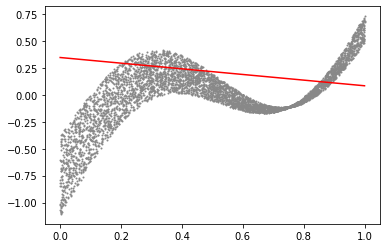

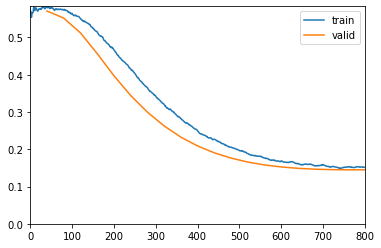

In [7]:
model = nn.Linear(in_features=1, out_features=1, bias=True)
loss_func = nn.MSELoss()

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    #opt_func=SGD,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()],
)

learner.fit_one_cycle(n_epoch=20)#, lr=1e-1)

Evaluate the MSE. By eye, how well does it fit?

*Your narrative response here*

**Use `nn.Sequential` to put two `nn.Linear` layers back to back.**

Use 200 dimensions as the hidden dimension (the `out_features` of the first and the `in_features` of the second).

epoch,train_loss,valid_loss,mae,time
0,0.076896,0.060568,0.193306,00:00
1,0.064024,0.056066,0.197431,00:00
2,0.060285,0.055012,0.196246,00:00
3,0.058994,0.057400,0.196784,00:00
4,0.059697,0.055593,0.197318,00:00
5,0.058579,0.055444,0.194570,00:00
6,0.060050,0.057272,0.196782,00:00
7,0.060139,0.062123,0.201648,00:00
8,0.059397,0.056402,0.199813,00:00
9,0.058377,0.055292,0.195673,00:00


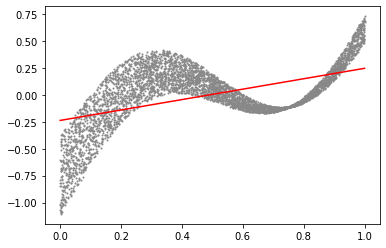

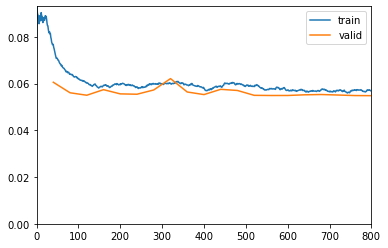

In [19]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=500, bias=True),
    nn.Linear(in_features=500, out_features=1, bias=True),
)
loss_func = nn.MSELoss()

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    #opt_func=SGD,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()],
)

learner.fit_one_cycle(n_epoch=20)#, lr=1e-2)

**Neural Net Regression**

* Definitely use `fit_one_cycle` here!
* Try several different `set_seed`s here to ensure that your results aren't a fluke.

epoch,train_loss,valid_loss,mae,time
0,0.065824,0.058309,0.193286,00:00
1,0.059487,0.052458,0.190079,00:00
2,0.055094,0.048524,0.182909,00:00
3,0.050231,0.041798,0.168023,00:00
4,0.043346,0.033046,0.149226,00:00
5,0.035533,0.025784,0.133994,00:00
6,0.027646,0.018322,0.106754,00:00
7,0.021691,0.015893,0.092819,00:00
8,0.018069,0.013908,0.088142,00:00
9,0.015775,0.013335,0.084696,00:00


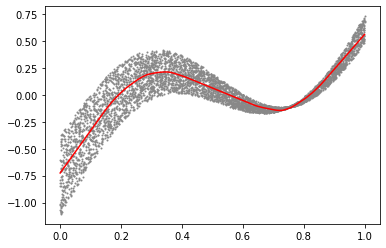

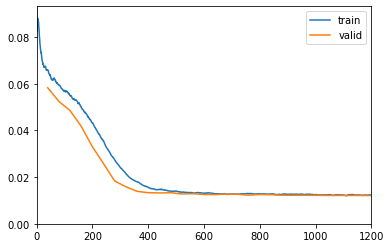

In [18]:
set_seed(0)
model = nn.Sequential(
    nn.Linear(1, 500),
    nn.ReLU(),
    nn.Linear(500, 1)
)

learner = Learner(
    dls=dataloaders,
    model=model,
    loss_func=loss_func,
    #opt_func=SGD,#partial(SGD, mom=0.9),
    #wd=1e-3,
    metrics=[mae],
    cbs=[ShowPredictions(), ShowGraphCallback()]
)
#learner.lr_find()
learner.fit_one_cycle(n_epoch=30)#, lr_max=.1)

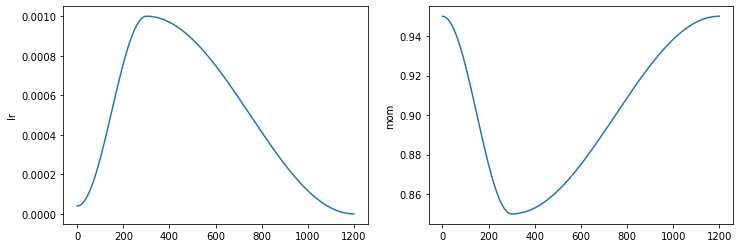

In [10]:
learner.recorder.plot_sched()

## Analysis

Despite having a hidden layer like the final model, the second model never gave us anything more than a straight line. Why not?

## Extension (optional)

What effect does the size of the hidden layer have on the quality of the fit?

What effect does the choice of nonlinearity ("activation function") have? Try a few others: `Tanh`, `Sigmoid`, `LeakyReLU`,  `PReLU`, ... Early research in neural nets used smooth functions like `Tanh` and `Sigmoid` almost exclusively; do you think the `ReLU` was a good idea?